In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline

In [9]:
X_train = pd.read_csv('X_train_origin.csv')
y_train= pd.read_csv('y_train_origin.csv')
# double check if the data is correct
X_train.head(5)

,perc_premium_paid_by_cash_credit,age_in_days,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,logIncome,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Rural,residence_area_type_Urban
0,0.429,12058.0,0.0,0.0,0.0,99.02,13.0,3300.0,5.550302,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.010,21546.0,0.0,0.0,0.0,99.89,21.0,18000.0,5.498517,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.917,17531.0,2.0,3.0,1.0,98.69,7.0,3300.0,4.925003,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.049,15341.0,0.0,0.0,0.0,99.57,9.0,9600.0,5.398825,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.052,31400.0,0.0,0.0,0.0,99.87,12.0,9600.0,5.298154,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [10]:
y_train.shape

(79853, 1)

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
scaler.fit(X_train.as_matrix())
X_scaled = scaler.transform(X_train)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y_train['renewal'].values, 
                                                      random_state=666, train_size=0.80)

/Users/jessie/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Boosting Tree

In [13]:
from xgboost import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import roc_auc_score, roc_curve, auc

/Users/jessie/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jessie/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [14]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [15]:
# A parameter grid for XGBoost
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, 
                                   n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] min_child_weight=5, gamma=5, subsample=1.0, colsample_bytree=1.0, max_depth=3 
[CV] min_child_weight=5, gamma=5, subsample=1.0, colsample_bytree=1.0, max_depth=3 
[CV] min_child_weight=5, gamma=5, subsample=1.0, colsample_bytree=1.0, max_depth=3 
[CV] min_child_weight=1, gamma=1.5, subsample=0.6, colsample_bytree=0.8, max_depth=5 
[CV]  min_child_weight=5, gamma=5, subsample=1.0, colsample_bytree=1.0, max_depth=3, score=0.8379823326905582, total=  20.1s
[CV] min_child_weight=1, gamma=1.5, subsample=0.6, colsample_bytree=0.8, max_depth=5 
[CV]  min_child_weight=5, gamma=5, subsample=1.0, colsample_bytree=1.0, max_depth=3, score=0.8472358462164545, total=  20.3s
[CV] min_child_weight=1, gamma=1.5, subsample=0.6, colsample_bytree=0.8, max_depth=5 
[CV]  min_child_weight=5, gamma=5, subsample=1.0, colsample_bytree=1.0, max_depth=3, score=0.8320148022487245, total=  20.1s
[CV] min_child_weight=5, gamma=1, subsample=0.8, colsam

[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  1.7min finished



 Time taken: 0 hours 1 minutes and 59.85 seconds.


In [16]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 All results:
{'std_train_score': array([0.00278614, 0.00202636, 0.00195105, 0.00369368, 0.00207026]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_colsample_bytree': masked_array(data=[1.0, 0.8, 0.8, 0.6, 1.0],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'rank_test_score': array([3, 5, 4, 1, 2], dtype=int32), 'split0_train_score': array([0.85071601, 0.88843131, 0.88183661, 0.86252047, 0.87139038]), 'mean_fit_time': array([19.62052536, 30.85175625, 26.66322335, 18.07443531, 21.89041471]), 'std_test_score': array([0.00626199, 0.00647972, 0.00651463, 0.00667263, 0.00599801]), 'std_score_time': array([0.01909741, 0.03555923, 0.1003208 ,

In [17]:
#modelXGBoost = XGBClassifier() 
#modelXGBoost.fit(X_train,y_train) # train 
modelXGBoost = random_search.best_estimator_


y_train_prob = modelXGBoost.predict_proba(X_train)[:, 1]
y_valid_prob = modelXGBoost.predict_proba(X_valid)[:, 1] # validate with ROC curve
# note: [:, 0] because we only one possibility since the other is correlated

fpr, tpr, threshold = roc_curve(y_train, y_train_prob, pos_label=1)
fpr_test, tpr_test, threshold_test = roc_curve(y_valid, y_valid_prob, pos_label=1)

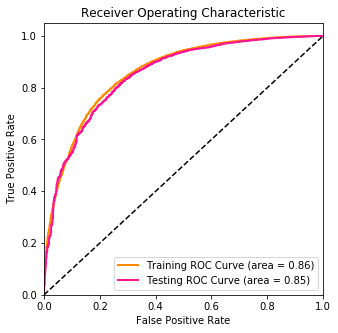

In [18]:
roc_auc = auc(fpr, tpr)
roc_auc_test = auc(fpr_test, tpr_test)

# plot ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, \
         color='darkorange', lw=2, linestyle='-', label='Training ROC Curve (area = {0:.2f})'.format(roc_auc))
plt.plot(fpr_test, tpr_test, \
         color='deeppink', lw=2, linestyle='-', label='Testing ROC Curve (area = {0:.2f})'.format(roc_auc_test))
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Generating Results

In [19]:
df_test = pd.read_csv('processed_test.csv')
X_test = df_test.drop('id',1).as_matrix()
X_test_scaled = scaler.transform(X_test)

In [20]:
result = modelXGBoost.predict(X_test_scaled)
df_test['renewal'] = result
result_proba = modelXGBoost.predict_proba(X_test_scaled)[:, 1]
df_test['renewal_proba'] = result_proba

/Users/jessie/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
def net_revenue_neg(incentive,proba,premium):
    effort = 10*(1-np.exp(-incentive/400))
    delta_p = 20*(1-np.exp(-effort/5))
    revenue = (proba+delta_p)*premium - incentive
    return -revenue

def constraint_1(incentive,proba):
    """
    final probability of renewal can't be larger than 1
    """
    effort = 10*(1-np.exp(-incentive/400))
    delta_p = 20*(1-np.exp(-effort/5))
    return 1- (proba + delta_p)

In [22]:
import scipy.optimize as optimize
x_start = 1650
bound = [(0,10000)]

opt_incent = np.zeros([df_test.shape[0],1])
for i,r in df_test.iterrows():
    # randomly choose x_start
    x_start = np.random.randint(low = 0, high=1000, size=1, dtype='l')
    constraints = ({'type': 'ineq', 'fun':  lambda x, proba = r.renewal_proba:  constraint_1(x,proba = r.renewal_proba)})
    opt_result = optimize.minimize(net_revenue_neg, x_start, args=(r.renewal_proba, r.premium),
                                   bounds = bound, constraints =  constraints, method='SLSQP')
    if opt_result['x']:
        opt_incent[i] = opt_result['x']
    else:
        opt_incent[i] = 0

In [23]:
df_test['incentives'] = opt_incent
df_test[['id','renewal','incentives']].to_csv('result_XGBoost.csv',index = False)